# Assignment 2 - Geopandas

Create a map that visualizes the preferences of cities/municipalities between Jollibee and Mcdonalds in 'Metropolitan Manila'. Your map should distinctly show:
1. The locations of the Jollibee and Mcdonalds Establishments
1. The "preference" between the two
1. The bottom two cities in terms of number or restaurants/population

# Code

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2022", 
                 password="g5!V%T1Vmd", 
                 host="192.168.212.99",
                 port=32771)

In [3]:
ph_shp = gpd.read_postgis(
    '''
    SELECT *
    FROM gadm.ph g
    ''',
    conn,
    geom_col='geom'
)

In [4]:
# Let's read our financial and population data from our last meeting 
finpop = pd.read_csv('financial_pop(1).csv')
finpop

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman
...,...,...,...,...,...,...,...,...,...,...,...,...
1622,NaN,15.448920,5.801291,165.833472,116.742464,49.091008,0.0,30.375550,40.505854,29.068270,Camarines Sur,Tinambac
1623,NaN,3.881869,2.064453,59.176489,50.055428,9.121061,0.0,0.000000,0.000000,33.135557,Camarines Sur,Camaligan
1624,NaN,4.867135,2.615213,144.692431,100.076373,44.616059,0.0,0.502352,0.502352,106.534443,Camarines Sur,Lagonoy
1625,NaN,5.261260,1.360630,95.936120,61.682604,34.253516,0.0,13.592182,13.949405,40.976700,Camarines Sur,Balatan


In [5]:
# Now let's read our osm points as mm_pts. Filter by looking at points insde 'Metropolitan Manila' and amenity != 'None'
jb_mc_pts = gpd.read_postgis(
    '''
    SELECT g.name_1, g.name_2, p.osm_id, 
    CASE
        WHEN lower(p.name) LIKE '%jollibee%' THEN 'Jollibee'
        WHEN lower(p.name) LIKE '%mc do%' THEN 'Mcdonalds'
        WHEN lower(p.name) LIKE '%mcdo%' THEN 'Mcdonalds'
        END AS name,
    p.way
    FROM gadm.ph g 
    JOIN ph_point p ON st_within(p.way, g.geom)
    WHERE p.amenity != 'None'
    AND g.name_1 = 'Metropolitan Manila'
    AND (
        lower(p.name) LIKE '%jollibee%'
        OR lower(p.name) LIKE '%mcdo%'
        OR lower(p.name) LIKE '%mc do%'
        )
    ''',
    conn,
    geom_col='way'
)
jb_mc_pts

,name_1,name_2,osm_id,name,way
0,Metropolitan Manila,Muntinlupa,2197156471,Jollibee,POINT (121.04510 14.38967)
1,Metropolitan Manila,Muntinlupa,821585644,Jollibee,POINT (121.03830 14.39326)
2,Metropolitan Manila,Muntinlupa,3721647225,Jollibee,POINT (121.04576 14.37747)
3,Metropolitan Manila,Muntinlupa,663455348,Mcdonalds,POINT (121.04599 14.37776)
4,Metropolitan Manila,Muntinlupa,684988102,Mcdonalds,POINT (121.04504 14.39448)
...,...,...,...,...,...
409,Metropolitan Manila,Marikina,4817955121,Mcdonalds,POINT (121.11579 14.65034)
410,Metropolitan Manila,Marikina,1360075650,Mcdonalds,POINT (121.11661 14.65011)
411,Metropolitan Manila,Marikina,4634402790,Jollibee,POINT (121.11336 14.65931)
412,Metropolitan Manila,Marikina,748188282,Jollibee,POINT (121.11345 14.65943)


In [6]:
res_pts = gpd.read_postgis(
    '''
    SELECT g.name_1, g.name_2, COUNT(p.osm_id), g.geom
    FROM gadm.ph g 
    JOIN ph_point p ON st_within(p.way, g.geom)
    WHERE p.amenity = 'restaurant'
    AND g.name_1 = 'Metropolitan Manila'
    GROUP BY 1, 2, 4
    ''',
    conn,
    geom_col='geom'
)

In [7]:
# Notice that we really can't see our points. We can use pandas functions to limit our scope to Metro Manila, mm_shp
mm_shp = ph_shp[ph_shp['name_1'] == 'Metropolitan Manila']
mm_shp

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
959,973,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.13_1,Pateros,None,None,Lungsod|Siyudad,City,137606,PH.MM.PT,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ..."
960,974,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.14_1,Quezon City,None,None,Lungsod|Siyudad,City,137404,PH.MM.QE,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ..."
973,965,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.5_1,Mandaluyong,"Mandaluyong, City of",None,Lungsod|Siyudad,City,137401,PH.MM.MD,"MULTIPOLYGON (((121.05405 14.57747, 121.05408 ..."
974,966,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.6_1,Manila,"City of Manila|Manila, City of",None,Lungsod|Siyudad,City,133900,PH.MM.MN,"MULTIPOLYGON (((120.99142 14.56218, 120.98849 ..."
975,967,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.7_1,Marikina,"Marikina, City of",None,Lungsod|Siyudad,City,137402,PH.MM.MR,"MULTIPOLYGON (((121.07346 14.61962, 121.07432 ..."
976,968,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.8_1,Muntinlupa,"Muntinlupa, City of",None,Lungsod|Siyudad,City,137603,PH.MM.MU,"MULTIPOLYGON (((121.02339 14.35760, 121.02313 ..."
981,961,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.1_1,Kalookan City,None,None,Lungsod|Siyudad,City,137501,PH.MM.KL,"MULTIPOLYGON (((121.02068 14.71426, 121.02071 ..."
982,962,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.2_1,Las Piñas,"Las Piñas, City of",None,Lungsod|Siyudad,City,137601,PH.MM.LP,"MULTIPOLYGON (((120.97972 14.49306, 120.98000 ..."
983,963,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.3_1,Makati City,"Makati, City of",None,Lungsod|Siyudad,City,137602,PH.MM.MK,"MULTIPOLYGON (((121.06578 14.53872, 121.06594 ..."
984,964,PHL,Philippines,PHL.47_1,Metropolitan Manila,None,PHL.47.4_1,Malabon,None,None,Lungsod|Siyudad,City,137502,PH.MM.ML,"MULTIPOLYGON (((120.95800 14.65938, 120.95796 ..."


In [8]:
mm_shp_pref = gpd.read_postgis(
    '''
    SELECT *,
        CASE
            WHEN jb_count > mc_count THEN 'Jollibee'
            WHEN mc_count > jb_count THEN 'Mcdonalds'
            ELSE 'Both'
        END AS Preference
    FROM (
        SELECT
        g.name_1, g.name_2,
        g.geom,
        jb.count as jb_count,
        mc.count as mc_count
    FROM gadm.ph g
    JOIN (
        SELECT g.name_1, g.name_2, COUNT(p.osm_id)
        FROM gadm.ph g
        JOIN ph_point p ON st_within(p.way, g.geom)
        WHERE p.amenity != 'None'
        AND g.name_1 = 'Metropolitan Manila'
        AND lower(p.name) LIKE '%jollibee%'
        GROUP BY 1, 2
    ) jb ON jb.name_2 = g.name_2
    JOIN (
        SELECT g.name_1, g.name_2, COUNT(p.osm_id)
        FROM gadm.ph g
        JOIN ph_point p ON st_within(p.way, g.geom)
        WHERE p.amenity != 'None'
        AND g.name_1 = 'Metropolitan Manila'
        AND lower(p.name) LIKE '%mcdo%'
        GROUP BY 1, 2
    ) mc ON mc.name_2 = g.name_2
    WHERE g.name_1 = 'Metropolitan Manila'
    ) A
    ''',
    conn,
    geom_col='geom'
)

In [9]:
mm_shp_pref

,name_1,name_2,geom,jb_count,mc_count,preference
0,Metropolitan Manila,Pateros,"MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...",2,1,Jollibee
1,Metropolitan Manila,Quezon City,"MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...",61,40,Jollibee
2,Metropolitan Manila,Mandaluyong,"MULTIPOLYGON (((121.05405 14.57747, 121.05408 ...",6,8,Mcdonalds
3,Metropolitan Manila,Manila,"MULTIPOLYGON (((120.99142 14.56218, 120.98849 ...",42,27,Jollibee
4,Metropolitan Manila,Marikina,"MULTIPOLYGON (((121.07346 14.61962, 121.07432 ...",11,4,Jollibee
5,Metropolitan Manila,Muntinlupa,"MULTIPOLYGON (((121.02339 14.35760, 121.02313 ...",13,6,Jollibee
6,Metropolitan Manila,Kalookan City,"MULTIPOLYGON (((121.02068 14.71426, 121.02071 ...",9,3,Jollibee
7,Metropolitan Manila,Las Piñas,"MULTIPOLYGON (((120.97972 14.49306, 120.98000 ...",7,6,Jollibee
8,Metropolitan Manila,Makati City,"MULTIPOLYGON (((121.06578 14.53872, 121.06594 ...",25,21,Jollibee
9,Metropolitan Manila,Malabon,"MULTIPOLYGON (((120.95800 14.65938, 120.95796 ...",4,2,Jollibee


In [10]:
_, _, maxx, maxy = mm_shp.bounds.max()
minx, miny, _, _ = mm_shp.bounds.min()

In [11]:
res_pts.columns = ['shp_province', 'shp_municipality', 'count', 'geom']
res_pop = res_pts.merge(finpop, on=['shp_province', 'shp_municipality'])
res_pop['restaurant_per_population'] = res_pop['count'] / res_pop['pop']
res_bot2 = res_pop.sort_values(['restaurant_per_population']).iloc[:2]
res_bot2

,shp_province,shp_municipality,count,geom,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,restaurant_per_population
0,Metropolitan Manila,Kalookan City,23,"MULTIPOLYGON (((121.02068 14.71426, 121.02071 ...",1583978.0,2548.299770,2078.233727,4718.102455,2885.275622,1832.826833,372.406907,307.132984,548.347680,671.177751,0.000015
14,Metropolitan Manila,Taguig,16,"MULTIPOLYGON (((121.05622 14.46785, 121.05588 ...",804915.0,5071.963996,3693.742053,6559.588487,4226.739028,2332.849458,715.166475,276.331991,369.505142,3233.401866,0.000020


In [12]:
res_bot2.iloc[0]

shp_province                                                 Metropolitan Manila
shp_municipality                                                   Kalookan City
count                                                                         23
geom                           MULTIPOLYGON (((121.02068329 14.71426105, 121....
pop                                                                    1583978.0
tot_local_sources                                                     2548.29977
tot_tax_revenue                                                      2078.233727
tot_current_oper_income                                              4718.102455
total_oper_expenses                                                  2885.275622
net_oper_income                                                      1832.826833
total_non_income_receipts                                             372.406907
capital_expenditure                                                   307.132984
total_non_oper_expenditures 

# Plot

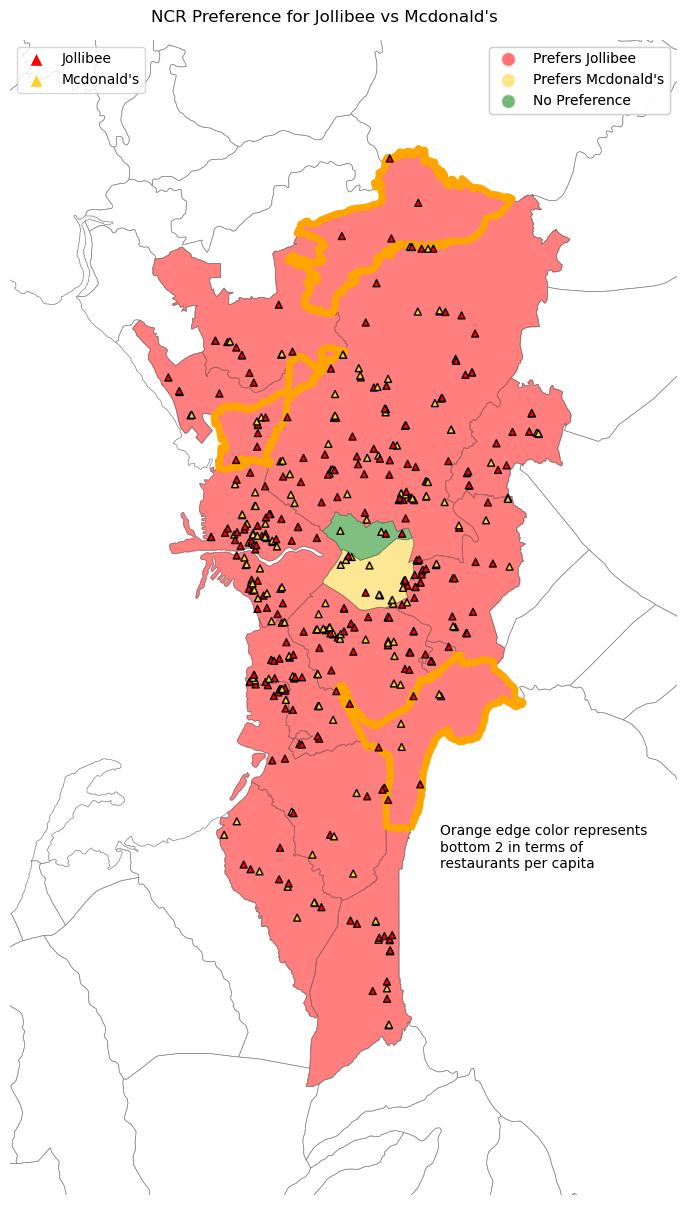

In [21]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(15,15))

color_map1 = {'Jollibee': 'red', 'Mcdonalds': '#FCD12A'}
jb_mc_pts['color'] = jb_mc_pts['name'].map(color_map1)

color_map2 = {'Jollibee': 'red', 'Mcdonalds': '#FCD12A', 'Both': 'green'}
mm_shp_pref['color'] = mm_shp_pref['preference'].map(color_map2)

jb_mc_pts.plot(
    ax=ax,
    markersize=25,
    marker='^',
    zorder=10,
    color=jb_mc_pts['color'],
    edgecolor='black'
)
res_bot2.plot(
    ax=ax,
    linewidth=5,
    zorder=5,
    edgecolor='orange',
    facecolor='none'
)

mm_shp_pref.plot(
    ax=ax,
    edgecolor='gray',
    color=mm_shp_pref['color'],
    linewidth=0.5,
    zorder=2,
    alpha=0.5
)
ph_shp.plot(
    ax=ax,
    edgecolor='grey',
    color='white',
    linewidth = 0.5,
    zorder=1
)
legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Jollibee'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='#FCD12A', markersize=10, label="Mcdonald's")
]
ax.add_artist(ax.legend(handles=legend_elements, loc='upper left'))
legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.5, label='Prefers Jollibee'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FCD12A', markersize=10, alpha=0.5, label="Prefers Mcdonald's"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, alpha=0.5, label="No Preference")
]
ax.add_artist(ax.legend(handles=legend_elements2, loc='upper right'))
ax.annotate('Orange edge color represents\nbottom 2 in terms of\nrestaurants per capita',
             size=10,
             xy=(121.1, 14.4),
             xytext=(121.07, 14.45)
           )
fig.suptitle("NCR Preference for Jollibee vs Mcdonald's", y=0.9)
ax.set_xlim(minx-0.05, maxx+0.05)
ax.set_ylim(miny-0.05, maxy+0.05)
ax.set_axis_off()
plt.show()